## Converting points to raster

In [44]:
%pip install rasterio


[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


### Import Libraries and set paths

In [45]:
import math
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import rasterio

from streetscapes import conf
from streetscapes.functions import load_city_subset

In [46]:
data_dir = conf.DATA_DIR / "data"
parquet_dir =  data_dir / "parquet"

### Create Geopandas dataframe

Load streetscapes dataset and select the city you want to analyse. 

In [47]:
all = pd.read_parquet(parquet_dir / f"streetscapes.parquet")
amsterdam = load_city_subset("Amsterdam")

Streetscapes | 2025-02-21@00:34:01 | Loading 'Amsterdam.parquet'...


Create geopandas dataframe and set projection

In [48]:
amsterdam_gdf = gpd.GeoDataFrame(amsterdam, geometry=gpd.points_from_xy(amsterdam.lon, amsterdam.lat), crs="EPSG:4326")
amsterdam_projected = amsterdam_gdf.to_crs(27700)

### Create template raster

To rasterise points, you first need to create a template raster with the same extents and CRS as your input point data. 

In [60]:
bounds = amsterdam_projected.total_bounds
horizontal_resolution = 100
transform = rasterio.transform.from_origin(
    west=bounds[0], 
    north=bounds[3], 
    xsize=horizontal_resolution, 
    ysize=horizontal_resolution
)
transform

Affine(100.0, 0.0, np.float64(867880.4174896937),
       0.0, -100.0, np.float64(297747.6811687431))

Calculate output shape

In [61]:
rows = math.ceil((bounds[3] - bounds[1]) / horizontal_resolution)
cols = math.ceil((bounds[2] - bounds[0]) / horizontal_resolution)
shape = (rows, cols)
shape

(17, 17)

Create pairs of coordinates to value

In [62]:
g = [(g, v) for g, v in amsterdam_projected[['geometry', 'Beautiful']] \
        .dropna(subset='Beautiful')
        .to_numpy() \
        .tolist()]
g[:5]

[(<POINT (869003.632 296912.539)>, 7.68),
 (<POINT (868978.043 296853.212)>, 5.02),
 (<POINT (868884.567 296549.961)>, 8.63),
 (<POINT (869410.563 297145.998)>, 4.47),
 (<POINT (869461.77 296358.256)>, 6.1)]

Rasterise: Map to template raster

In [66]:
raster = rasterio.features.rasterize(
    shapes=g,
    out_shape=shape,
    transform=transform,
)
raster

array([[0.  , 0.  , 0.  , 8.73, 5.58, 9.18, 7.13, 7.85, 6.27, 3.86, 7.47,
        3.41, 3.22, 5.61, 6.33, 0.  , 0.  ],
       [7.74, 4.63, 7.5 , 8.85, 4.83, 9.32, 5.1 , 1.12, 6.74, 7.17, 8.39,
        7.13, 5.56, 6.15, 8.97, 8.07, 0.  ],
       [3.86, 3.8 , 5.62, 5.56, 4.33, 3.61, 8.28, 3.89, 2.84, 5.64, 4.73,
        5.5 , 2.31, 3.65, 6.99, 0.  , 0.  ],
       [5.59, 6.9 , 8.2 , 6.62, 8.73, 4.64, 8.  , 2.9 , 3.46, 7.31, 5.95,
        4.93, 2.53, 8.94, 8.82, 5.5 , 0.  ],
       [7.21, 7.12, 5.99, 3.51, 8.24, 6.01, 9.13, 8.18, 1.52, 7.28, 9.27,
        6.67, 8.53, 2.48, 7.51, 7.15, 0.  ],
       [1.99, 7.84, 7.73, 2.7 , 7.02, 5.73, 5.19, 9.02, 3.91, 4.25, 5.49,
        3.84, 4.33, 8.12, 6.46, 5.79, 0.  ],
       [9.51, 7.82, 6.38, 7.35, 5.81, 7.6 , 8.39, 9.57, 6.87, 5.34, 5.87,
        5.19, 8.33, 4.9 , 6.91, 7.33, 0.  ],
       [8.67, 8.35, 6.57, 8.26, 8.49, 6.03, 7.2 , 6.9 , 5.59, 8.74, 6.18,
        8.05, 6.57, 5.34, 5.47, 8.19, 0.  ],
       [7.46, 8.83, 5.51, 1.57, 8.52, 9.62, 6.87

### Plot the output

<Axes: >

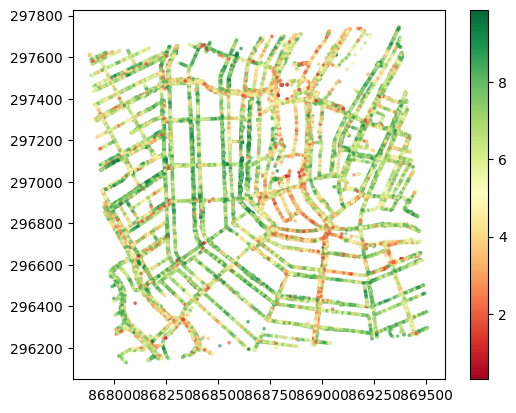

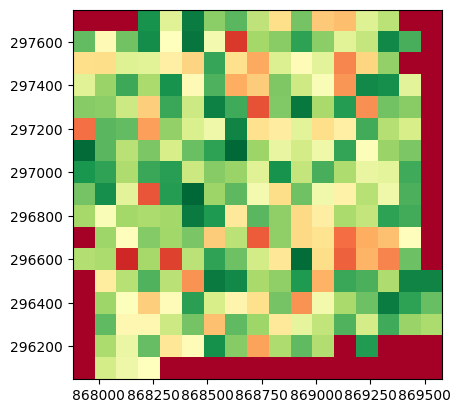

In [67]:
# Input points
fig, ax = plt.subplots()
amsterdam_projected.plot(column='Beautiful', ax=ax, cmap='RdYlGn', legend=True, markersize=3, figsize=(10, 10), alpha=0.5)
# Summed attribute values
fig, ax = plt.subplots()
rasterio.plot.show(raster, transform=transform, ax=ax, cmap='RdYlGn')